### Case Condition (Brief)

### Задание 1:  
***Имеется набор данных со следующими столбцами:***  
    1) Идентификатор документа  
    2) Идентификатор товара  
    3) Операция документа  
    4) Дата документа  
    5) Идентификатор филиала, создавшего документ  
    
> *Идентификатор товара – уникальный номер единицы товара, находящейся в сервисном центре*

Этот набор данных связан со справочником филиалов. Справочник содержит следующие поля:  
    1) Идентификатор филиала  
    2) Наименование филиала  
    3) Наименование региона филиала  
    
***Необходимо рассчитать среднее время нахождения товара в сервисном центре:   
    1) Общая динамика по месяцам   
    2) Динамика по неделям в разрезе регионов  
Вывести нормативный срок по всей компании.  
Графически представить динамику отклонения от нормы по каждому региону.***

### Задание 2:  
Вы работаете сотрудником, осуществляющим прием клиентов в сервисном центре.  
К вам пришел клиент.  
Какие варианты развития событий могут последовать далее?  
Опишите их.  

### Import libraries and Reading the data.

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# Получение пути к файлам
catalog_path = "./data/Справочник.csv"
data_path = "./data/data.csv"

In [3]:
# Создание DF
catalog = pd.read_csv(catalog_path)
data = pd.read_csv(data_path)

### Review Data (Understanding the Data)

In [4]:
print(catalog.isnull().sum())
print(50 * "-")
print(data.isnull().sum())

Наименование филиала            0
Наименование региона филиала    0
Идентификатор филиала           0
dtype: int64
--------------------------------------------------
Идентификатор документа            0
Идентификатор товара               0
Вид операции документа             0
Дата документа                     0
Идентификатор филиалы документа    0
dtype: int64


In [5]:
catalog.head()

,Наименование филиала,Наименование региона филиала,Идентификатор филиала
0,Казань СЦ на Чистопольской,Верхняя Волга,"b'U\x8b\xecN\xb5\xe4\x02+\xcf\x9cT""ivr\n'"
1,Воткинск СЦ,Верхняя Волга,b'\xb5Mv\xe3\x86\xc3\x9a\x0b\x10\xb2\xba\xfa\x...
2,Чистополь СЦ,Верхняя Волга,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"
3,Тверь СЦ,Центральный,b'\xe4\x04!)\xa7l\xb0B#=i\xf8\x89\x1a\x8b\x1f'
4,Рославль СЦ,Черноземье,b'\xb85\xa2\xe7\x1b\x8d\xd5\xff\x0bd>\xdcR:\xd...


In [6]:
data.head()

,Идентификатор документа,Идентификатор товара,Вид операции документа,Дата документа,Идентификатор филиалы документа
0,b'\x8f\x03\xf0[gd\xef.P\xb0\\P\xe8f\xb6\x9f',b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,Прием товара,2019-01-01,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...
1,b'O\x99\x903\x11Zd\x16\x8e\x00\xafM\xb8\x02\xa...,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',Прием товара,2019-01-01,b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...
2,b'\xc3y\xdc\xf9\xc9\xe1\x0cC\x13U\xdby\xac\x97...,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,Прием товара,2019-01-01,b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93'
3,b'9\xf4D`\x00\xf0\x00\xe3\xa8=\xea=N$\xf2\xc9',b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,Прием товара,2019-01-01,b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...
4,b'\x10\x0b?\xd9ehT\x181\xed\xdd}\x1c(\x98`',b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,Прием товара,2019-01-01,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"


### Splitting data.
>Разделяю данные по признаку (Вид операции документа) на два новых Датасета.

In [7]:
# Получение фрейма по признаку (Вид операции документа == Прием товара) 
df_acceptance_of_goods = pd.concat([
    data['Идентификатор документа'],
    data['Идентификатор товара'],
    data['Вид операции документа'].loc[data['Вид операции документа'] == 'Прием товара'],
    data['Дата документа'].loc[data['Вид операции документа'] == 'Прием товара'], 
    data['Идентификатор филиалы документа']
], axis=1)

# Удаление несоответствующих эл-тов списка.
df_acceptance_of_goods = df_acceptance_of_goods.dropna()

df_acceptance_of_goods.head()

,Идентификатор документа,Идентификатор товара,Вид операции документа,Дата документа,Идентификатор филиалы документа
0,b'\x8f\x03\xf0[gd\xef.P\xb0\\P\xe8f\xb6\x9f',b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,Прием товара,2019-01-01,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...
1,b'O\x99\x903\x11Zd\x16\x8e\x00\xafM\xb8\x02\xa...,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',Прием товара,2019-01-01,b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...
2,b'\xc3y\xdc\xf9\xc9\xe1\x0cC\x13U\xdby\xac\x97...,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,Прием товара,2019-01-01,b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93'
3,b'9\xf4D`\x00\xf0\x00\xe3\xa8=\xea=N$\xf2\xc9',b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,Прием товара,2019-01-01,b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...
4,b'\x10\x0b?\xd9ehT\x181\xed\xdd}\x1c(\x98`',b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,Прием товара,2019-01-01,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"


In [8]:
# Получение фрейма по признаку (Вид операции документа == Выдача товара) 
df_exit_of_goods_from_service_1 = pd.concat([    
    data['Идентификатор товара'], 
    data['Дата документа'].loc[data['Вид операции документа'] == 'Выдача товара'], 
    data['Вид операции документа'].loc[data['Вид операции документа'] == 'Выдача товара'],
], axis=1)
# Удаление несоответствующих эл-тов списка.
df_exit_of_goods_from_service_1 = df_exit_of_goods_from_service_1.dropna()

df_exit_of_goods_from_service_1.head()

,Идентификатор товара,Дата документа,Вид операции документа
8217,b'\x87\x1e\xc6\xf3C\xdb\x0c\xc3\x8a\\`\xa1\xd4...,2019-01-02,Выдача товара
8218,b'\xad@\xa8\x97\xdf\x80\x08\xd1Pz\xe2\xc6H/C\x83',2019-01-02,Выдача товара
8219,b'n8\x95\xf6(D\xe8\x82F\x07\xba\xb2\xa1\x90\x0...,2019-01-02,Выдача товара
8220,b'\x16i\x91\x86\x93/d\xd4\xe8\xc05B\x9b\x0e\x1...,2019-01-02,Выдача товара
8221,b'\xa0\xaf\xccR[J\x1ea\xfcj\x03+\xe5VSx',2019-01-02,Выдача товара


In [9]:
# Левое соединение двух фреймов по колонне "Идентификатор товара".
df_list_of_received_and_issued = df_acceptance_of_goods.merge(df_exit_of_goods_from_service_1, left_on='Идентификатор товара', right_on='Идентификатор товара')
df_list_of_received_and_issued.head()

,Идентификатор документа,Идентификатор товара,Вид операции документа_x,Дата документа_x,Идентификатор филиалы документа,Дата документа_y,Вид операции документа_y
0,b'\x8f\x03\xf0[gd\xef.P\xb0\\P\xe8f\xb6\x9f',b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,Прием товара,2019-01-01,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,2019-01-20,Выдача товара
1,b'O\x99\x903\x11Zd\x16\x8e\x00\xafM\xb8\x02\xa...,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',Прием товара,2019-01-01,b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...,2019-01-18,Выдача товара
2,b'\xc3y\xdc\xf9\xc9\xe1\x0cC\x13U\xdby\xac\x97...,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,Прием товара,2019-01-01,b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93',2019-02-04,Выдача товара
3,b'9\xf4D`\x00\xf0\x00\xe3\xa8=\xea=N$\xf2\xc9',b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,Прием товара,2019-01-01,b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...,2019-01-27,Выдача товара
4,b'\x10\x0b?\xd9ehT\x181\xed\xdd}\x1c(\x98`',b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,Прием товара,2019-01-01,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'",2019-01-09,Выдача товара


#### Добавление колонки со сроками нахождения в СЦ.

In [10]:
# Преобразование "str" в "datetime64".
# Необходимо для вычитания дат.
df_list_of_received_and_issued["Дата документа_x"] = pd.to_datetime(df_list_of_received_and_issued["Дата документа_x"])
df_list_of_received_and_issued["Дата документа_y"] = pd.to_datetime(df_list_of_received_and_issued["Дата документа_y"])

In [11]:
# "Месяц" в отдельную колонку.
df_list_of_received_and_issued['Месяц'] = df_list_of_received_and_issued['Дата документа_x'].dt.month

# Добавление новой колонки со сроками нахождения в СЦ.
df_list_of_received_and_issued['Срок(дней)'] = (df_list_of_received_and_issued['Дата документа_y'] - df_list_of_received_and_issued['Дата документа_x']).dt.days

In [12]:
df_list_of_received_and_issued.head()

,Идентификатор документа,Идентификатор товара,Вид операции документа_x,Дата документа_x,Идентификатор филиалы документа,Дата документа_y,Вид операции документа_y,Месяц,Срок(дней)
0,b'\x8f\x03\xf0[gd\xef.P\xb0\\P\xe8f\xb6\x9f',b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,Прием товара,2019-01-01,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,2019-01-20,Выдача товара,1,19
1,b'O\x99\x903\x11Zd\x16\x8e\x00\xafM\xb8\x02\xa...,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',Прием товара,2019-01-01,b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...,2019-01-18,Выдача товара,1,17
2,b'\xc3y\xdc\xf9\xc9\xe1\x0cC\x13U\xdby\xac\x97...,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,Прием товара,2019-01-01,b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93',2019-02-04,Выдача товара,1,34
3,b'9\xf4D`\x00\xf0\x00\xe3\xa8=\xea=N$\xf2\xc9',b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,Прием товара,2019-01-01,b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...,2019-01-27,Выдача товара,1,26
4,b'\x10\x0b?\xd9ehT\x181\xed\xdd}\x1c(\x98`',b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,Прием товара,2019-01-01,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'",2019-01-09,Выдача товара,1,8


In [13]:
mean_days_by_month = pd.DataFrame(df_list_of_received_and_issued.groupby('Месяц').mean()).reset_index()
mean_days_by_month

,Месяц,Срок(дней)
0,1,21.207099
1,2,21.245289
2,3,21.174793
3,4,21.218228
4,5,21.216056
5,6,21.179176
6,7,21.192127
7,8,21.238414
8,9,21.229594
9,10,21.290566


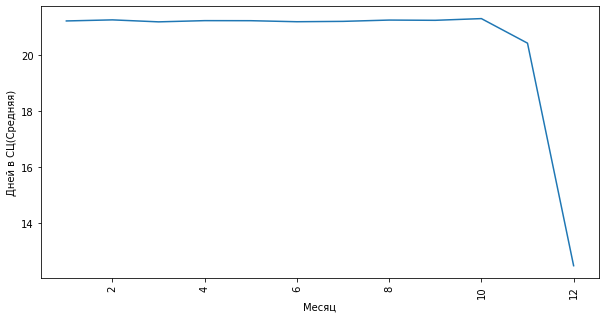

In [14]:
# Вывод результата на график.
plt.figure(figsize=(10,5))
ax = sns.lineplot(x=mean_days_by_month['Месяц'], y=mean_days_by_month['Срок(дней)'], data=mean_days_by_month)
plt.xlabel('Месяц')
plt.ylabel('Дней в СЦ(Средняя)')
plt.xticks(rotation=90);

In [29]:
df_mean = pd.DataFrame(df_month['Срок(дней)'].value_counts().sort_index())

for i in range(1, 13):   
    
    df_month = df_list_of_received_and_issued.loc[df_list_of_received_and_issued['Месяц'] == i]
    
    df_mean[f'{i}'] = pd.DataFrame(df_month['Срок(дней)'].value_counts().sort_index())

# df_mean = df_mean.reset_index()
# df_mean.rename(columns={'index': 'Дней в СЦ'},inplace=True)
df_mean = df_mean.drop(columns='Срок(дней)')
df_mean.head()

,1,2,3,4,5,6,7,8,9,10,11,12
1,2493,2228,2581,2330,2568,2424,2546,2536,2441,2609,2344,2575
2,2530,2267,2541,2454,2543,2490,2540,2481,2451,2487,2448,2404
3,2492,2294,2541,2486,2520,2514,2524,2495,2427,2520,2493,2401
4,2542,2252,2629,2497,2549,2460,2556,2514,2435,2532,2418,2261
5,2595,2282,2578,2485,2562,2431,2495,2532,2482,2456,2506,2200


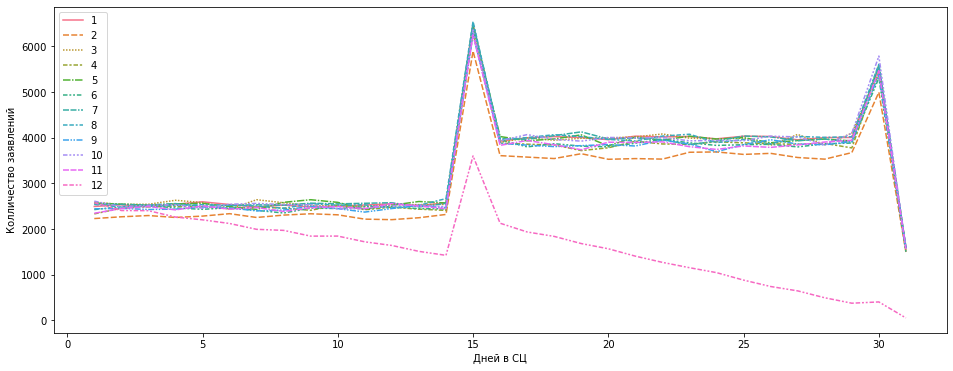

In [32]:
# Вывод на график
# Вывод результата на график.
plt.figure(figsize=(16,6))
sns.lineplot(data=df_mean)
plt.xlabel('Дней в СЦ')
plt.ylabel('Колличество заявлений');